In [1]:
import numpy as np
from typing import List, Tuple
import random
import matplotlib.pyplot as plt
import time
from copy import deepcopy

In [3]:
class VRPSolver:
    def __init__(self, distances: np.ndarray, demands: List[float],
                 vehicle_capacity: float, num_vehicles: int, max_iterations: int = 1000):
        self.distances = distances
        self.demands = demands
        self.vehicle_capacity = vehicle_capacity
        self.num_vehicles = num_vehicles
        self.num_customers = len(demands) - 1  #Excluyendo al depósito
        self.max_iterations = max_iterations

    def generate_initial_solution(self) -> List[List[int]]:
        unassigned = list(range(1, self.num_customers + 1))
        routes = []

        while unassigned:
            route = [0] 
            remaining_capacity = self.vehicle_capacity

            while unassigned and remaining_capacity > 0:
                #Mejor opción de cliente
                feasible = [c for c in unassigned if self.demands[c] <= remaining_capacity]
                if not feasible:
                    break

                last = route[-1]
                next_customer = min(feasible,
                                    key=lambda x: self.distances[last][x])

                route.append(next_customer)
                remaining_capacity -= self.demands[next_customer]
                unassigned.remove(next_customer)

            route.append(0)  #Regresa al depósito
            routes.append(route)

            if len(routes) >= self.num_vehicles:
                for customer in unassigned:
                    routes[-1].insert(-1, customer)
                break

        return routes

    def calculate_route_cost(self, route: List[int]) -> float:
        return sum(self.distances[route[i]][route[i + 1]]
                   for i in range(len(route) - 1))

    def calculate_total_cost(self, solution: List[List[int]]) -> float:
        return sum(self.calculate_route_cost(route) for route in solution)

    def check_capacity_constraint(self, route: List[int]) -> bool:
        return sum(self.demands[i] for i in route[1:-1]) <= self.vehicle_capacity

    def get_neighborhood_moves(self, solution: List[List[int]]) -> List[Tuple]:
        moves = []
        num_routes = len(solution)

        for route_idx, route in enumerate(solution):
            for i in range(1, len(route) - 2):
                for j in range(i + 1, len(route) - 1):
                    moves.append(("swap_within", route_idx, i, j))
        for i in range(num_routes):
            for j in range(i + 1, num_routes):
                route1, route2 = solution[i], solution[j]
                for idx1 in range(1, len(route1) - 1):
                    for idx2 in range(1, len(route2) - 1):
                        moves.append(("swap_between", i, j, idx1, idx2))

        for from_route_idx, from_route in enumerate(solution):
            for to_route_idx, to_route in enumerate(solution):
                if from_route_idx != to_route_idx:
                    for customer_idx in range(1, len(from_route) - 1):
                        for position in range(1, len(to_route)):
                            moves.append(("relocate", from_route_idx, to_route_idx, customer_idx, position))

        return moves

    def apply_move(self, solution: List[List[int]], move: Tuple) -> List[List[int]]:
        new_solution = deepcopy(solution)
        move_type = move[0]

        if move_type == "swap_within":
            _, route_idx, pos1, pos2 = move
            route = new_solution[route_idx]
            route[pos1], route[pos2] = route[pos2], route[pos1]
        elif move_type == "swap_between":
            _, route1_idx, route2_idx, pos1, pos2 = move
            route1, route2 = new_solution[route1_idx], new_solution[route2_idx]
            route1[pos1], route2[pos2] = route2[pos2], route1[pos1]
        elif move_type == "relocate":
            _, from_route_idx, to_route_idx, customer_idx, position = move
            customer = new_solution[from_route_idx].pop(customer_idx)
            new_solution[to_route_idx].insert(position, customer)

        return new_solution

    def is_feasible(self, solution: List[List[int]]) -> bool:
        return all(self.check_capacity_constraint(route) for route in solution)

    def solve_tabu_search(self, tabu_tenure: int = 20) -> Tuple[List[List[int]], float, List[float]]:
        current_solution = self.generate_initial_solution()
        best_solution = deepcopy(current_solution)
        current_cost = self.calculate_total_cost(current_solution)
        best_cost = current_cost
        
        tabu_list = []
        tabu_tenures = {}
        cost_history = [current_cost]
        
        for iteration in range(self.max_iterations):
            neighborhood = self.get_neighborhood_moves(current_solution)
            best_move = None
            best_neighbor_cost = float('inf')

            for move in neighborhood:
                neighbor = self.apply_move(current_solution, move)

                if self.is_feasible(neighbor):
                    neighbor_cost = self.calculate_total_cost(neighbor)
                    customer_pair = self.extract_move_customers(move, current_solution)

    
                    if customer_pair not in tabu_list or neighbor_cost < best_cost:
                        if neighbor_cost < best_neighbor_cost:
                            best_neighbor_cost = neighbor_cost
                            best_move = move
                            best_neighbor = neighbor

            if best_move is None:
                break
            current_solution = best_neighbor
            current_cost = best_neighbor_cost
            customer_pair = self.extract_move_customers(best_move, current_solution)
            tabu_list.append(customer_pair)
            tabu_tenures[customer_pair] = iteration + tabu_tenure

            tabu_list = [pair for pair in tabu_list if tabu_tenures[pair] > iteration]

            if current_cost < best_cost:
                best_solution = deepcopy(current_solution)
                best_cost = current_cost

            cost_history.append(current_cost)

        return best_solution, best_cost, cost_history

    def extract_move_customers(self, move: Tuple, solution: List[List[int]]) -> Tuple[int, int]:
        move_type = move[0]
        if move_type == "swap_within":
            _, route_idx, pos1, pos2 = move
            customer1 = solution[route_idx][pos1]
            customer2 = solution[route_idx][pos2]
        elif move_type == "swap_between":
            _, route1_idx, route2_idx, pos1, pos2 = move
            customer1 = solution[route1_idx][pos1]
            customer2 = solution[route2_idx][pos2]
        elif move_type == "relocate":
            _, from_route_idx, _, customer_idx, _ = move
            customer1 = solution[from_route_idx][customer_idx]
            customer2 = -1  
        else:
            customer1 = customer2 = -1 
        return (customer1, customer2)

    def solve_simulated_annealing(self, initial_temp: float = 1000,
                                  cooling_rate: float = 0.95) -> Tuple[List[List[int]], float, List[float]]:
        current_solution = self.generate_initial_solution()
        best_solution = deepcopy(current_solution)
        current_cost = self.calculate_total_cost(current_solution)
        best_cost = current_cost
        temperature = initial_temp
        cost_history = [current_cost]

        for iteration in range(self.max_iterations):
            moves = self.get_neighborhood_moves(current_solution)
            move = random.choice(moves)
            neighbor = self.apply_move(current_solution, move)

            if self.is_feasible(neighbor):
                neighbor_cost = self.calculate_total_cost(neighbor)
                cost_diff = neighbor_cost - current_cost
                if (cost_diff < 0 or
                        random.random() < np.exp(-cost_diff / temperature)):
                    current_solution = neighbor
                    current_cost = neighbor_cost

                    if current_cost < best_cost:
                        best_solution = deepcopy(current_solution)
                        best_cost = current_cost

            temperature *= cooling_rate
            cost_history.append(current_cost)

        return best_solution, best_cost, cost_history

In [5]:
def generate_random_problem(num_customers: int, area_size: int = 100) -> Tuple[np.ndarray, List[float], List[Tuple[float, float]]]:
    locations = [(random.uniform(0, area_size), random.uniform(0, area_size))
                 for _ in range(num_customers + 1)]  # Include depot

    
    distances = np.zeros((num_customers + 1, num_customers + 1))
    for i in range(num_customers + 1):
        for j in range(num_customers + 1):
            if i != j:
                x1, y1 = locations[i]
                x2, y2 = locations[j]
                distances[i][j] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    
    demands = [0] 
    demands.extend(random.uniform(10, 30) for _ in range(num_customers))

    return distances, demands, locations

In [7]:
def generate_random_problem(num_customers: int, area_size: int = 100) -> Tuple[np.ndarray, List[float], List[Tuple[float, float]]]:
    locations = [(random.uniform(0, area_size), random.uniform(0, area_size))
                 for _ in range(num_customers + 1)]  # Include depot

    
    distances = np.zeros((num_customers + 1, num_customers + 1))
    for i in range(num_customers + 1):
        for j in range(num_customers + 1):
            if i != j:
                x1, y1 = locations[i]
                x2, y2 = locations[j]
                distances[i][j] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    
    demands = [0] 
    demands.extend(random.uniform(10, 30) for _ in range(num_customers))

    return distances, demands, locations

In [25]:
def run_vrp_comparison(num_customers: int = 20,
                       num_vehicles: int = 6,
                       vehicle_capacity: float = 100,
                       area_size: int = 100,
                       max_iterations: int = 100):
    
    print("\nGenerando instancia aleatoria de VRP...")
    print(f"Número de clientes: {num_customers}")
    print(f"Número de vehículos: {num_vehicles}")
    print(f"Capacidad del vehículo: {vehicle_capacity}")

    distances, demands, locations = generate_random_problem(num_customers, area_size)

    print("\nEstadísticas de demanda:")
    print(f"Demanda total: {sum(demands):.2f}")
    print(f"Demanda promedio por cliente: {sum(demands[1:]) / num_customers:.2f}")
    print(f"Demanda mínima: {min(demands[1:]):.2f}")
    print(f"Demanda máxima: {max(demands[1:]):.2f}")

    solver = VRPSolver(
        distances=distances,
        demands=demands,
        vehicle_capacity=vehicle_capacity,
        num_vehicles=num_vehicles,
        max_iterations=max_iterations
    )

    print("\nResolviendo con Búsqueda Tabú...")
    start_time = time.time()
    tabu_solution, tabu_cost, tabu_history = solver.solve_tabu_search()
    tabu_time = time.time() - start_time

    print("Resolviendo con Recocido Simulado...")
    start_time = time.time()
    sa_solution, sa_cost, sa_history = solver.solve_simulated_annealing(
        initial_temp=1000,
        cooling_rate=0.95
    )
    sa_time = time.time() - start_time

    print("\nComparación de Resultados:")
    print("-" * 60)
    print(f"{'Método':<20} {'Costo':<12} {'Tiempo (s)':<10} {'Rutas':<15}")
    print("-" * 60)
    print(f"{'Búsqueda Tabú':<20} {tabu_cost:<12.2f} {tabu_time:<10.2f} {len(tabu_solution)}")
    print(f"{'Recocido Simulado':<20} {sa_cost:<12.2f} {sa_time:<10.2f} {len(sa_solution)}")
    print("-" * 60)

    print("\nRutas de Búsqueda Tabú:")
    for i, route in enumerate(tabu_solution, 1):
        route_demand = sum(solver.demands[j] for j in route)
        route_cost = solver.calculate_route_cost(route)
        print(f"Ruta {i}: {route} (Demanda: {route_demand:.1f}, Costo: {route_cost:.1f})")

    print("\nRutas de Recocido Simulado:")
    for i, route in enumerate(sa_solution, 1):
        route_demand = sum(solver.demands[j] for j in route)
        route_cost = solver.calculate_route_cost(route)
        print(f"Ruta {i}: {route} (Demanda: {route_demand:.1f}, Costo: {route_cost:.1f})")

    #Gráfica de convergencia
    plt.figure(figsize=(12, 6))
    plt.plot(tabu_history, label='Búsqueda Tabú', color='blue', alpha=0.7)
    plt.plot(sa_history, label='Recocido Simulado', color='red', alpha=0.7)
    plt.xlabel('Iteración')
    plt.ylabel('Costo de la Solución')
    plt.title('Comparación de Convergencia de Métodos de Resolución VRP')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.axhline(y=tabu_cost, color='blue', linestyle='--', alpha=0.3)
    plt.axhline(y=sa_cost, color='red', linestyle='--', alpha=0.3)
    plt.text(len(tabu_history), tabu_cost, f' Tabú Final: {tabu_cost:.1f}',
             verticalalignment='bottom', color='blue')
    plt.text(len(sa_history), sa_cost, f' RS Final: {sa_cost:.1f}',
             verticalalignment='top', color='red')

    plt.tight_layout()
    plt.show()

    #Rutas
    plot_routes(locations, tabu_solution, title='Solución de Búsqueda Tabú')
    plot_routes(locations, sa_solution, title='Solución de Recocido Simulado (enfriamiento)')



Generando instancia aleatoria de VRP...
Número de clientes: 20
Número de vehículos: 6
Capacidad del vehículo: 100

Estadísticas de demanda:
Demanda total: 370.89
Demanda promedio por cliente: 18.54
Demanda mínima: 10.62
Demanda máxima: 28.85

Resolviendo con Búsqueda Tabú...
Resolviendo con Recocido Simulado...

Comparación de Resultados:
------------------------------------------------------------
Método               Costo        Tiempo (s) Rutas          
------------------------------------------------------------
Búsqueda Tabú        701.02       2.49       4
Recocido Simulado    768.35       0.02       4
------------------------------------------------------------

Rutas de Búsqueda Tabú:
Ruta 1: [0, 10, 18, 15, 3, 19, 0] (Demanda: 97.6, Costo: 102.6)
Ruta 2: [0, 7, 4, 20, 9, 1, 16, 0] (Demanda: 97.9, Costo: 172.5)
Ruta 3: [0, 5, 11, 13, 12, 0] (Demanda: 80.8, Costo: 186.3)
Ruta 4: [0, 6, 8, 17, 2, 14, 0] (Demanda: 94.5, Costo: 239.6)

Rutas de Recocido Simulado:
Ruta 1: [0, 18,

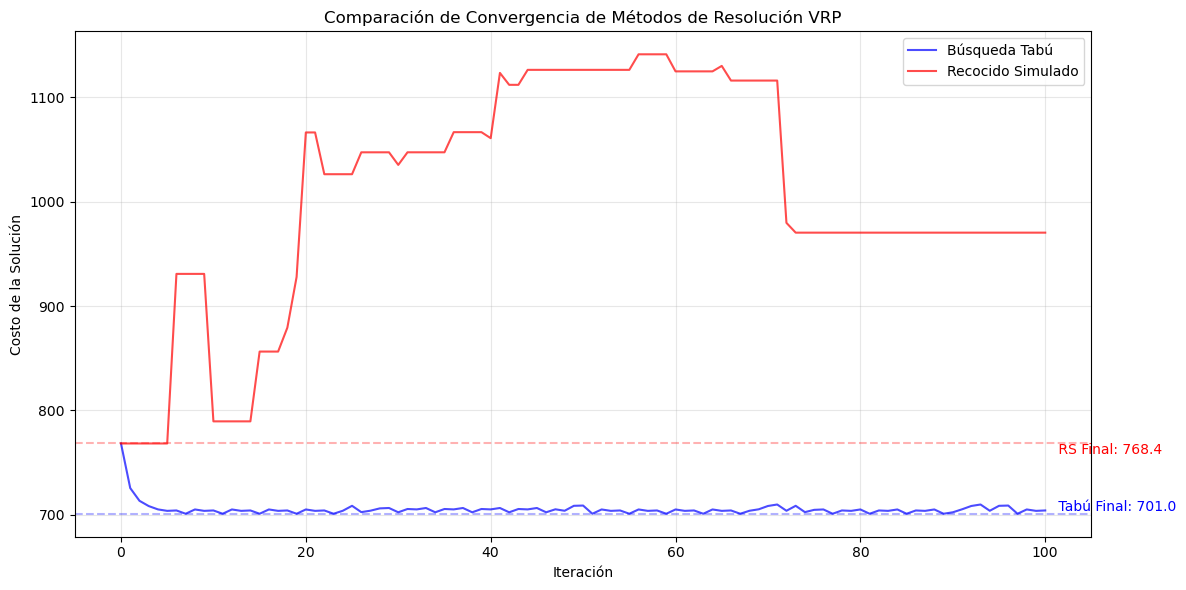

C:\Users\esco1\AppData\Local\Temp\ipykernel_21884\4290624288.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(solution))


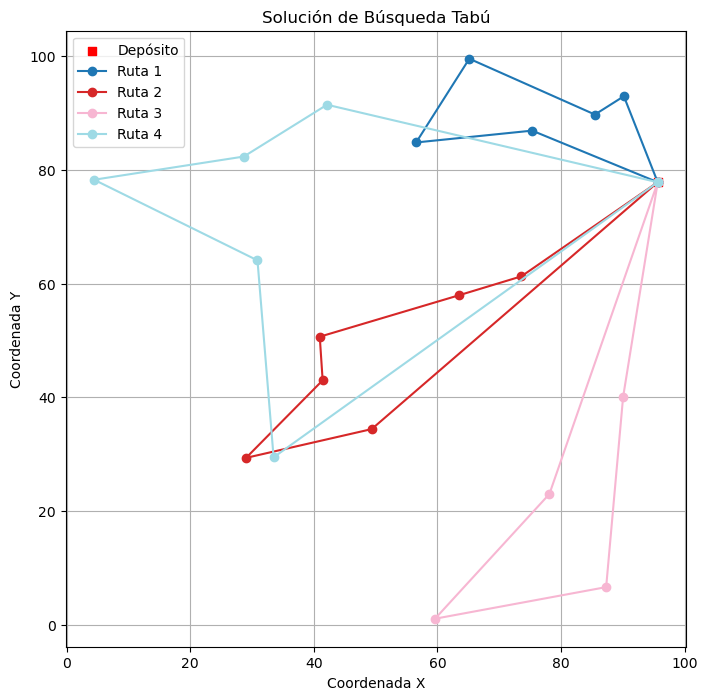

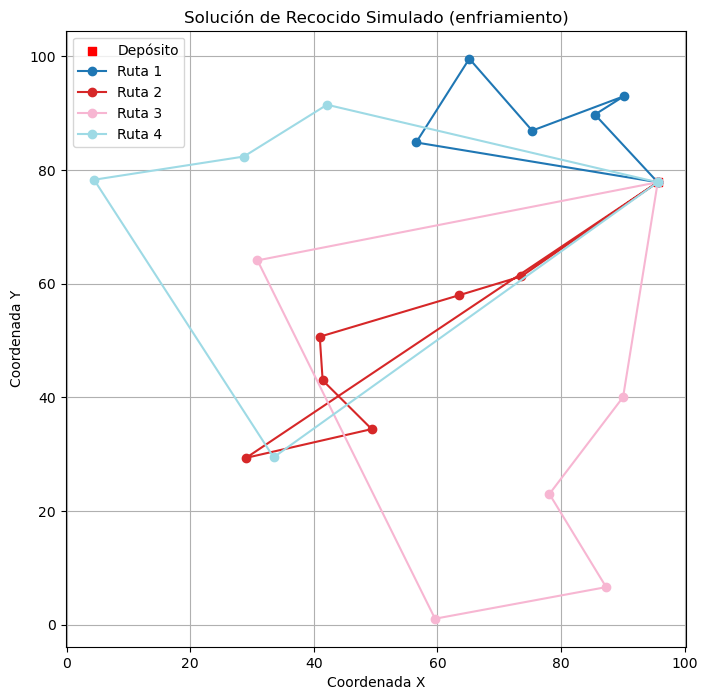

In [27]:
def plot_routes(locations: List[Tuple[float, float]], solution: List[List[int]], title: str):
    plt.figure(figsize=(8, 8))
    depot = locations[0]
    plt.scatter(depot[0], depot[1], c='red', marker='s', label='Depósito')

    colors = plt.cm.get_cmap('tab20', len(solution))

    for idx, route in enumerate(solution):
        route_locs = [locations[node] for node in route]
        xs, ys = zip(*route_locs)
        plt.plot(xs, ys, marker='o', color=colors(idx), label=f'Ruta {idx + 1}')

    plt.title(title)
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    run_vrp_comparison()